# [PREDICTING MOVIE REVENUE (IMDB)](https://www.kaggle.com/PromptCloudHQ/imdb-data)

### Given a data set of the 1,000 most popular movies on IMDB in the last 10 years, can you predict the revenue of a given movie?

Create a user for kaggle if not already done.
<br><br>



### Questions/Exercises:

**1.** Download the data programatically with python. 

(**Hint:** To generate your own kaggle.json file go to *your profile* -> *account* -> *Create new API Token*, and then place the file it in ~/.kaggle/)


In [1]:
#Using kaggle to downloading and unzipping the data
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('PromptCloudHQ/imdb-data', path='./', unzip=True)

You will now have to make a train-test-split of the data so that you have a way of verifying the model later. (We suggest 2/3 for training and 1/3 for testing)
	
Here is a link to the [train-test-split documentation for sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

**2.** Fit the training-data into a model, present it visually and reflect on wether it is a good fit or not.


In [2]:
#Loading the csv data into pandas dataframe
import pandas as pd

df = pd.read_csv("IMDB-Movie-Data.csv")

In [3]:
#Removing the revenue and other non-wanted features from the dataframe
%matplotlib notebook
import sklearn

df = df.drop(["Rank", "Title", "Description", "Director","Actors", "Rating", "Votes"], 1)

In [4]:
#Since genre is a string of genres seperated by a comma, we have to convert it to pd.Series
serie = pd.Series([genre_string.split(",") for genre_string in df["Genre"]])

#Now when the genres are converted to Series, we can make the dummies
genre_dummies = pd.get_dummies(serie.apply(pd.Series).stack()).sum(level=0)

In [5]:
#Getting the top genres
genre_counts = {}

for genre in genre_dummies.columns:
    count = 0
    for line in genre_dummies[genre]:
        if line != 0:
            count += 1 
    genre_counts[genre] = count

sorted_genres = sorted(genre_counts.items(), key=lambda kv: -kv[1])
genre_keys = list(dict(sorted_genres[:9]).keys())
genre_keys

['Drama',
 'Action',
 'Comedy',
 'Adventure',
 'Thriller',
 'Crime',
 'Romance',
 'Sci-Fi',
 'Horror']

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
#Setting the non-top genres to other
genre_dummies["Other genres"] = 0
genre_keys.append("Other genres")

for genre in genre_dummies.columns:
    if(genre not in genre_keys):
        genre_dummies["Other genres"] += genre_dummies[genre]
        genre_dummies = genre_dummies.drop(genre, 1)

#Setting Other genre values to binary value
def set_value(key):
    genre_dummies["Other genres"][key] = 1   
[set_value(key) for key, value in enumerate(genre_dummies["Other genres"]) if value > 1];

In [8]:
#Now we have vectors that can hold multiple dimentions of genres.
genre_dummies.head()

,Action,Adventure,Comedy,Crime,Drama,Horror,Romance,Sci-Fi,Thriller,Other genres
0,1,1,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,1
2,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,0,1


In [9]:
#Creating a copy of df without the genre column
df_no_genre = df.drop("Genre", 1)

In [10]:
#Merging the two df of vectors into one
vector_df = pd.merge(df_no_genre, genre_dummies, on=df.index).drop("key_0",1)

In [11]:
#Using the Imputer to replace NaN's by setting them to the median value
from sklearn.impute import SimpleImputer

NaN_imp = SimpleImputer(strategy="median")
NaN_imp.fit(vector_df)

vector_df = pd.DataFrame(NaN_imp.transform(vector_df), columns=vector_df.columns)

In [12]:
#making sure that all data is ints and not floats (linreg will not accept this aparently)
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()

for column in vector_df.columns:
    vector_df[column] = lab_enc.fit_transform(vector_df[column])

In [13]:
#Here we see that the labelencoder also optimizes the values by setting them to delta values
vector_df.head()

,Year,Runtime (Minutes),Revenue (Millions),Metascore,Action,Adventure,Comedy,Crime,Drama,Horror,Romance,Sci-Fi,Thriller,Other genres
0,8,43,783,61,1,1,0,0,0,0,0,1,0,0
1,6,46,623,50,0,1,0,0,0,0,0,1,0,1
2,10,39,646,47,0,0,0,0,0,1,0,0,1,0
3,10,30,761,43,0,0,1,0,0,0,0,0,0,1
4,10,45,781,24,1,1,0,0,0,0,0,0,0,1


In [14]:
#Train-Test-Splitting the data
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(vector_df.drop(["Revenue (Millions)"], 1))
y = np.array(vector_df["Revenue (Millions)"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [15]:
#Now we have two datasets, 3/4 of the data is for training, and 1/4 is for testing the model (selected randomly)
print("training-data: ", X_train.shape, " y:", y_train.shape)
print("test-data:     ", X_test.shape, " y:", y_test.shape)

training-data:  (750, 13)  y: (750,)
test-data:      (250, 13)  y: (250,)


In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


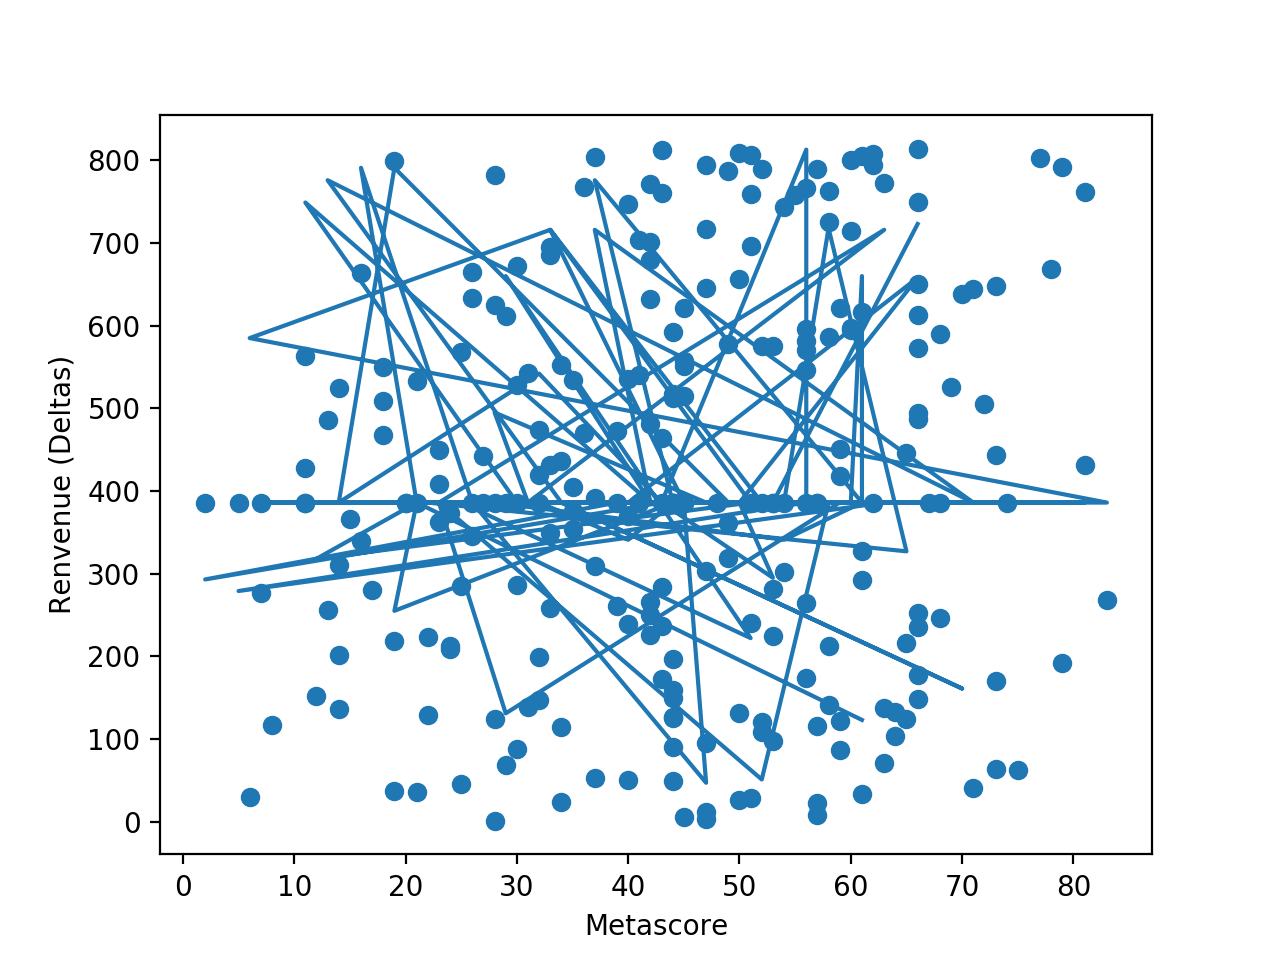

Text(0, 0.5, 'Renvenue (Deltas)')

In [17]:
from matplotlib import pyplot as plt

predict = logreg.predict(X_test)

plt.scatter(X_test[:,2], y_test)
plt.plot(X_test[:,2],predict)
plt.xlabel("Metascore")
plt.ylabel("Renvenue (Deltas)")

## This is kind of impossible to plot like this because i can only show 2 vector-dimentions, and the model is trained on 13 different dimentions in the vectors. I think this is why the values jumps around like this. 

### Do you have any suggestions?

**3.** Now take the test-data, test the model and evaluate how accurate the model is.

In [18]:
from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X_test)

print("Model Accuracy:",accuracy_score(y_test, y_pred) * 100, "%")

Model Accuracy: 14.000000000000002 %


## The model is only 14% accurate, which is not that useful for predicting. My personal theory is that there simply isn't a way to tell the revenue given the parameters that the dataset provides. A lot of other factors come into figuring out the revenue like budget, countries played in, price (3D) etc.



### Review Questions
1. Was the data downloaded programatically with python?
2. Was the data fitted into the model, presented visually and reflected on?
3. Was the revenue predicted using the model for the given metascores?